In [ ]:
import os
import re
import collections
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# If running on google colab:  Upload 'data.zip' file present in git repository to colab, uncomment below code and run it.
# !unzip data.zip

# Load data

In [ ]:
# Path to documents.
dir_path = os.getcwd()
rel_path = "data"
data_path = os.path.join(dir_path, rel_path)
news_groups = [f for f in os.listdir(data_path)]

In [ ]:
# Preprocess data: Remove all special characters, convert to lower case.
def data_preprocess(cur):
        cur = cur.lower()
        cur = re.sub("[^a-zA-Z,.']", ' ', cur)
        cur = re.sub('\.\.+', ' ', cur) 
        cur = " ".join(cur.split())
        return cur

In [ ]:
# Prepare dataset: Read data from docs. 
X = []
y = []
word_dictionary = {}

for category in news_groups:
    f_path = os.path.join(data_path,category)
    
    # Read data from all docs.
    for files in os.listdir(f_path):
        path = os.path.join(f_path,files)
        with open(path,'r',errors='ignore',encoding="utf8") as file:
            cur_doc = data_preprocess(file.read().replace('\n',' '))
            X.append(cur_doc)
            word_dictionary[category] = word_dictionary.get(category,'')+cur_doc
        y.append(category)

# Copy raw data to df dataframe.
df = pd.DataFrame({'doc':X,
                  'labels':y})

In [ ]:
print('Number of documents:', len(X))

Number of documents: 20417


# Distribution of the data

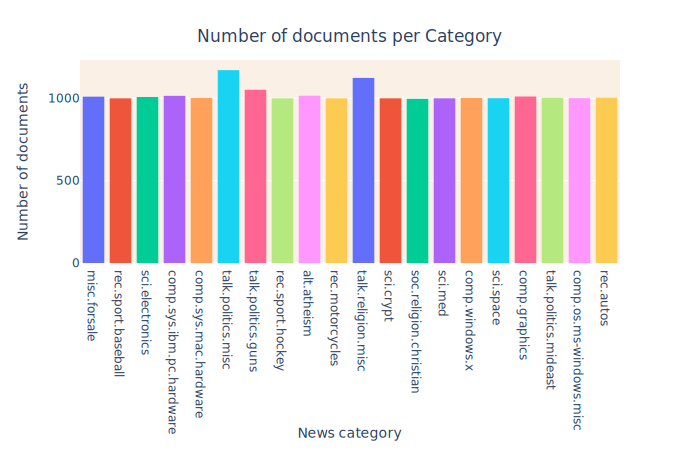

In [ ]:
# Histogram for news category labels.
fig = px.histogram(df,x='labels',color='labels')
fig.update_layout(
    title={
        'text': "Number of documents per Category",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="News category",
    yaxis_title='Number of documents',
    showlegend=False,
    plot_bgcolor='linen'
)
fig.show()

As we can see from above figure, there are over 1000 documents for each new category. Also, the data is evenly distributed without any imbalance. 

Category soc.religion.christian has minimum number of documents: 997

Category talk.politics.misc has maximum number of documents: 1171



# Average document word count per category

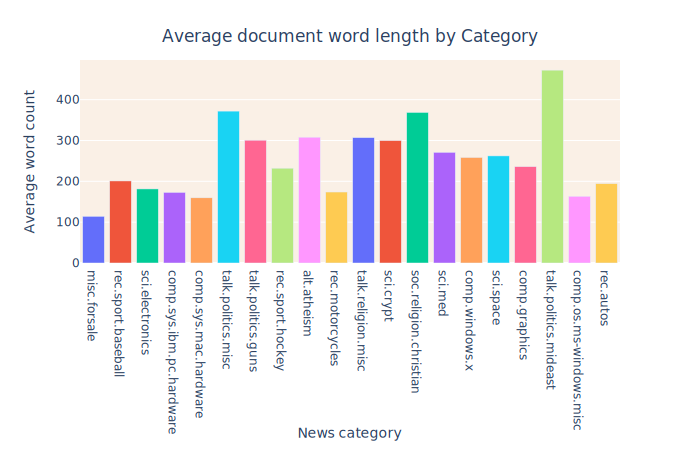

In [ ]:
# get unique news categories.(20)
categories = df["labels"].unique()
aux = []

# Get average word count for each category.
for i in categories:
    df_aux = df[df["labels"] == i]
    aux.append(np.mean(df_aux['doc'].apply(lambda x : len(x.split()))))

df_aux = pd.DataFrame({
    "Category" : categories,
    "Average": aux})

# Plot news category vs average word count.
fig = px.bar(df_aux,x="Category", y="Average",color="Category")
fig.update_layout(
    title={
        'text': "Average document word length by Category",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Average word count",
    xaxis_title='News category',
    showlegend=False,
    plot_bgcolor='linen'
)
fig.show()

From above figure, number of words in a document varies from category to category.

Category misc.forsale has minimum number of words per document: 114

Categories talk.politics.mideast has maximum number of words per document: 472

This helps in choosing the sequence length or embedding length while building machine learning models.


# Most frequent words in each news group

In [ ]:
frequent_words = {}

for i in word_dictionary:
    doc = word_dictionary[i]
    doc_counter = collections.Counter([word for word in doc.split() if word not in stop_words and len(word) > 2])
    most_freq = list(doc_counter.most_common(10))
    most_freq = list(zip(*most_freq))
    frequent_words[i] = most_freq[0]
    
most_frequent_words = pd.DataFrame(frequent_words)
print('Top 10 most frequent words in each news group:')
most_frequent_words

Top 10 most frequent words in each news group:


,misc.forsale,rec.sport.baseball,sci.electronics,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,talk.politics.misc,talk.politics.guns,rec.sport.hockey,alt.atheism,rec.motorcycles,talk.religion.misc,sci.crypt,soc.religion.christian,sci.med,comp.windows.x,sci.space,comp.graphics,talk.politics.mideast,comp.os.ms-windows.misc,rec.autos
0,mail,think,used,scsi,mac,think,gun,game,god,dod,god,key,god,medical,window,space,image,armenian,windows,car
1,asking,team,need,drive,apple,government,think,team,think,bike,think,encryption,think,health,file,launch,graphics,turkish,dos,cars
2,sale,game,power,ide,drive,mr.,fbi,hockey,believe,ride,jesus,government,jesus,think,server,nasa,jpeg,israel,file,think
3,shipping,year,want,card,problem,president,government,play,objective,think,believe,clipper,believe,patients,motif,think,bit,israeli,run,engine
4,price,baseball,ground,bus,bit,going,guns,think,moral,bmw,objective,chip,church,disease,program,shuttle,file,armenians,files,ford
5,dos,hit,circuit,controller,scsi,want,believe,games,time,got,time,public,christian,time,windows,earth,data,jews,program,car.
6,email,time,think,hard,power,stephanopoulos,law,win,religion,riding,want,security,christians,cancer,available,solar,available,jewish,win,oil
7,drive,games,copy,disk,monitor,believe,batf,players,evidence,time,christian,keys,bible,information,sun,time,color,arab,driver,used
8,sell,players,phone,dos,mhz,time,weapons,season,frank,motorcycle,theory,law,time,used,set,orbit,images,armenia,problem,speed
9,offer,runs,work,bit,need,health,time,period,atheists,dog,bible,used,christ,food,widget,data,software,government,card,dealer


## Comparision of most frequent words of alt.atheism and talk.religion.misc


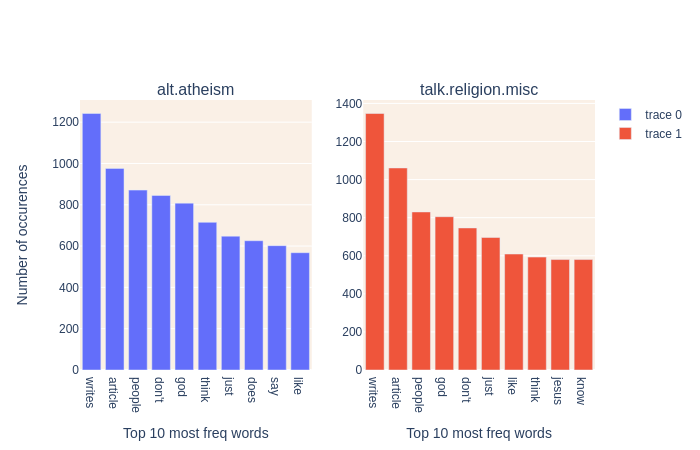

In [ ]:
fig = make_subplots(rows=1, cols=2,subplot_titles=("alt.atheism", "talk.religion.misc"))

# Plot top 10 most frequent words
def most_frequent_words_plot(i,cur_col):
    doc = word_dictionary[i]
    doc_counter = collections.Counter([word for word in doc.split() if word not in stop_words and len(word) > 2])
    most_freq = list(doc_counter.most_common(10))
    most_freq = list(zip(*most_freq))
    df_mf = pd.DataFrame({'word':most_freq[0], 'frequency':most_freq[1]})
    fig.add_trace(go.Bar(x = df_mf.word,y = df_mf.frequency),row=1, col=cur_col)
        
cur_col = 1
for category in ('alt.atheism','talk.religion.misc'):
    most_frequent_words_plot(category,cur_col)
    cur_col += 1
        
# Update xaxis properties
fig.update_xaxes(title_text="Top 10 most freq words", row=1, col=1)
fig.update_xaxes(title_text="Top 10 most freq words", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text='Number of occurences', row=1, col=1)

fig.update_layout(
    plot_bgcolor='linen')
fig.show()
    

As we can see from above plot, most frequent words of atheism and religion are very close! 

Words 'god','think','believe','objective' and 'time' are present in top 10 most frequent recurring words like of both atheism and religion categories. Similarly categories like politics.misc and politics.mideast are closely related. 

These observations later turned out to be crucial in building ML models. Any traditional machine learning model is not capable of capturing the context of the text. When we use bag of words or it's variations, we loose contextual meaning of the sentence. But the primary thing to consider here is few categories are closely realted. So using BOW or any traditional tokenizers, same words are repeated and thus model is confused easily while predicting the categories. This prompted me to choose distil-bert to build the model as it uses contextual embeddings.